In [1]:
import os
import json
import hoomd
import codecs

import numpy as np

import polychrom_hoomd.log as log
import polychrom_hoomd.build as build
import polychrom_hoomd.forces as forces
import polychrom_hoomd.render as render

In [2]:
# Generate uniform spherical distribution of 100,000 vertices by Gaussian sampling (https://mathworld.wolfram.com/SpherePointPicking.html)
number_of_vertices = 10000

vertex_positions = np.random.randn(number_of_vertices, 3)
vertex_positions /= np.linalg.norm(vertex_positions, axis=1, keepdims=True)

In [3]:
# Load vertices into HooMD snapshot
snapshot = build.get_simulation_box(box_length=3)

build.set_membrane_vertices(snapshot, vertex_positions)

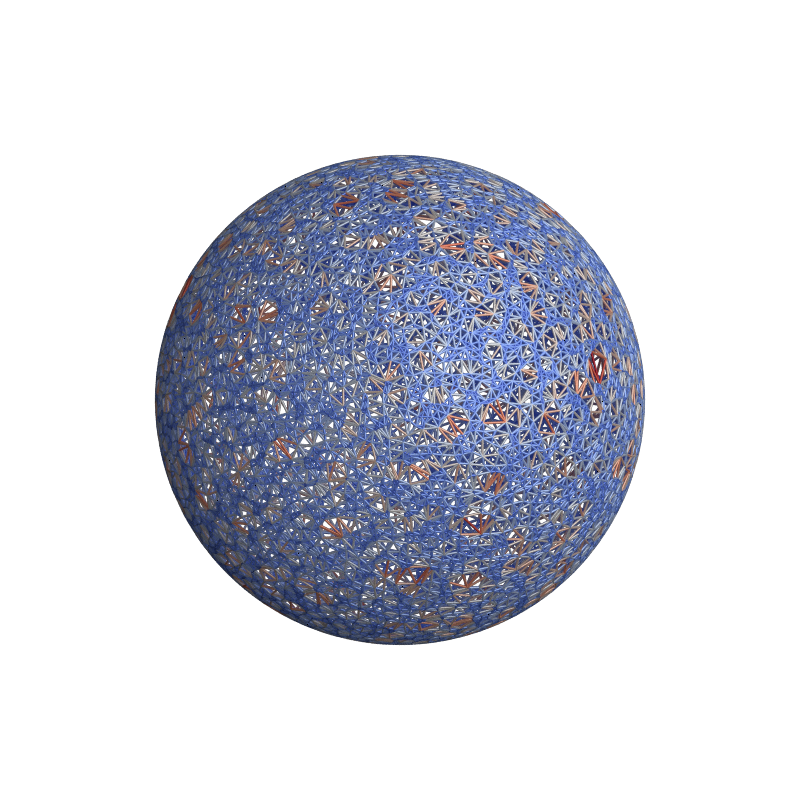

In [4]:
# Visualize the resulting mesh using Fresnel
vertex_rescale_factor = 0.01
snapshot.particles.diameter *= vertex_rescale_factor

render.fresnel(snapshot, outline=0, show='strains', cmap='coolwarm').static(height=800, width=800)

In [5]:
# That does not look very homogeneous! 
# Let's try to achieve a more regular mesh by solving the Thomson problem using HooMD (https://en.wikipedia.org/wiki/Thomson_problem)
vertex_positions_thomson = build.get_thomson_distribution(number_of_vertices)

HOOMD is running on the following GPU(s):
[0] NVIDIA A100 80GB PCIe 108 SM_8.0 @ 1.41 GHz, 81050 MiB DRAM
Simulation.timestep  Simulation.tps     Status.etr    Thermo.potential_energy
       5000            492.14226      0:03:13.033615        4.94488e+07      
       10000           564.91312      0:02:39.316535        4.94486e+07      
       15000           593.55955      0:02:23.203828        4.94478e+07      
       20000           608.82023      0:02:11.401678        4.94478e+07      
       25000           618.17579      0:02:01.324712        4.94476e+07      
       30000           623.96055      0:01:52.186580        4.94476e+07      
       35000           627.98833      0:01:43.505107        4.94475e+07      
       40000           630.86508      0:01:35.107499        4.94475e+07      
       45000           633.16241      0:01:26.865548        4.94475e+07      
       50000           634.91776      0:01:18.750357        4.94474e+07      
       55000           636.32390    

In [6]:
# Load vertices into new HooMD snapshot
snapshot_thomson = build.get_simulation_box(box_length=3)

build.set_membrane_vertices(snapshot_thomson, vertex_positions_thomson)

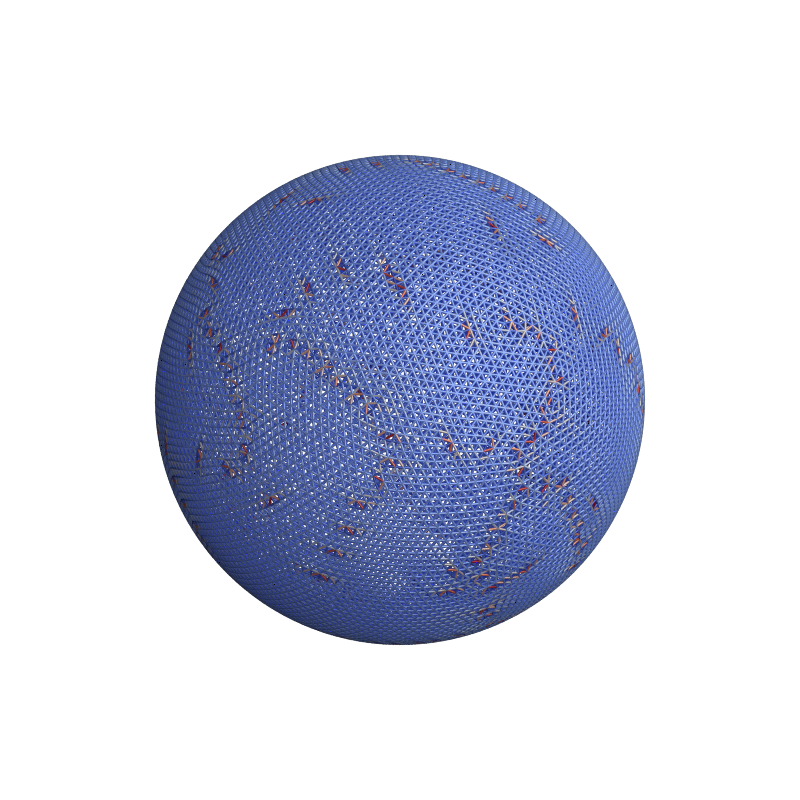

In [7]:
# That new mesh seems much better behaved! 
# Dislocation lines ('scars') still necessarily remain, as imposed by Euler's formula (https://en.wikipedia.org/wiki/Euler_characteristic) 
snapshot_thomson.particles.diameter *= vertex_rescale_factor

render.fresnel(snapshot_thomson, outline=0, show='strains', cmap='coolwarm').static(height=800, width=800)

In [8]:
# Rescale membrane diameter such that the mean mesh edge length equals 1 (i.e., 50 nm in physical units)
# This yields a membrane diameter of ~2.6 um
rescale_factor = np.sqrt(np.sqrt(3)*number_of_vertices/(8*np.pi))

vertex_rescale_factor *= rescale_factor
vertex_positions = vertex_positions_thomson * rescale_factor

In [9]:
# Initialise HooMD on the CPU or GPU, based on availability
hoomd_device = build.get_hoomd_device()

HOOMD is running on the following GPU(s):
[0] NVIDIA A100 80GB PCIe 108 SM_8.0 @ 1.41 GHz, 81050 MiB DRAM


In [10]:
# Generate RNG seed & initialize simulation object
rng_seed = os.urandom(2)
rng_seed = int(codecs.encode(rng_seed, 'hex'), 16)

print("Using entropy-harvested random seed: %d" % rng_seed)

Using entropy-harvested random seed: 29544


In [11]:
# Initialize simulation object
system = hoomd.Simulation(device=hoomd_device, seed=rng_seed)

In [12]:
# Load vertices into simulation
snapshot = build.get_simulation_box(box_length=9*rescale_factor)

build.set_membrane_vertices(snapshot, vertex_positions)
system.create_state_from_snapshot(snapshot)

In [13]:
# At T=300K, these numbers yield a membrane Young's modulus of 25 mN/m and bending modulus of 1e−19 J (https://arxiv.org/pdf/2107.02598)
with open("../data/force_dict_membrane.json", 'r') as dict_file:
    force_dict = json.load(dict_file)
    
print(json.dumps(force_dict, indent=4, sort_keys=True))

{
    "Bonded forces": {
        "Membrane": {
            "Rest length": 1.0,
            "Type": "Harmonic",
            "Wiggle distance": 0.028
        }
    },
    "Dihedral forces": {
        "Curvature": {
            "Phi_0": 0,
            "Stiffness": 30.0,
            "Type": "Harmonic"
        }
    },
    "External forces": {
        "Constant": {
            "Vector": {
                "Pull left": {
                    "x": -1000.0,
                    "y": 0,
                    "z": 0
                },
                "Pull right": {
                    "x": 1000.0,
                    "y": 0,
                    "z": 0
                }
            }
        }
    },
    "Non-bonded forces": {
        "Repulsion": {
            "Cutoff": 1.0,
            "Matrix": {
                "Vertices": {
                    "Vertices": 100.0
                }
            },
            "Type": "Polychrom"
        }
    }
}


In [14]:
# Set neighbor list & excluded volume
nl = hoomd.md.nlist.Cell(buffer=0.4)
repulsion_forces = forces.get_repulsion_forces(nl, **force_dict)

In [15]:
# Set bonded/dihedral potentials
bonded_forces = forces.get_bonded_forces(**force_dict)
dihedral_forces = forces.get_dihedral_forces(**force_dict)

/home1/tortora/.conda/envs/multistate/lib/python3.10/site-packages/hoomd/md/dihedral.py:131: FutureWarning: Harmonic is deprecated and will be removed in hoomd 4.0. Use Periodic instead.
  warnings.warn(


In [16]:
# Define elastic force field
relax_field = bonded_forces + dihedral_forces

In [17]:
# Setup minimisation engine to relax mesh structure
nve = hoomd.md.methods.NVE(filter=hoomd.filter.All())
fire = hoomd.md.minimize.FIRE(dt=1e-4, methods=[nve], forces=relax_field,
                              force_tol=5e-2, angmom_tol=5e-2, energy_tol=5e-2)

/home1/tortora/.conda/envs/multistate/lib/python3.10/site-packages/hoomd/md/methods/methods.py:699: FutureWarning: NVE is deprecated and wil be removed in hoomd 4.0. In version 4.0, use the ConstantVolume method without a thermostat.
  warnings.warn(


In [18]:
# Setup log and integrators
logger_relax = log.get_logger(system, quantities=['potential_energy'])

system.operations.integrator = fire
system.operations.writers.append(log.table_formatter(logger_relax, period=1e4))

In [19]:
# Run
system.run(2e5)

Simulation.timestep  Simulation.tps     Status.etr    Thermo.potential_energy
       10000           7852.68153     0:00:24.195557        15322.91747      
       20000           8613.51261     0:00:20.897398        13816.06221      
       30000           8900.48628     0:00:19.100080        13663.33949      
       40000           9047.80959     0:00:17.683838        13578.06481      
       50000           9138.87586     0:00:16.413397        13486.78234      
       60000           9199.38982     0:00:15.218401        13457.84867      
       70000           9245.71825     0:00:14.060563        13400.04377      
       80000           9281.03667     0:00:12.929590        13385.33232      
       90000           9307.81364     0:00:11.818028        13379.07828      
      100000          10285.26890     0:00:09.722643        13378.66547      
      110000          11299.23017     0:00:07.965144        13378.66547      
      120000          12310.61247     0:00:06.498458        1337

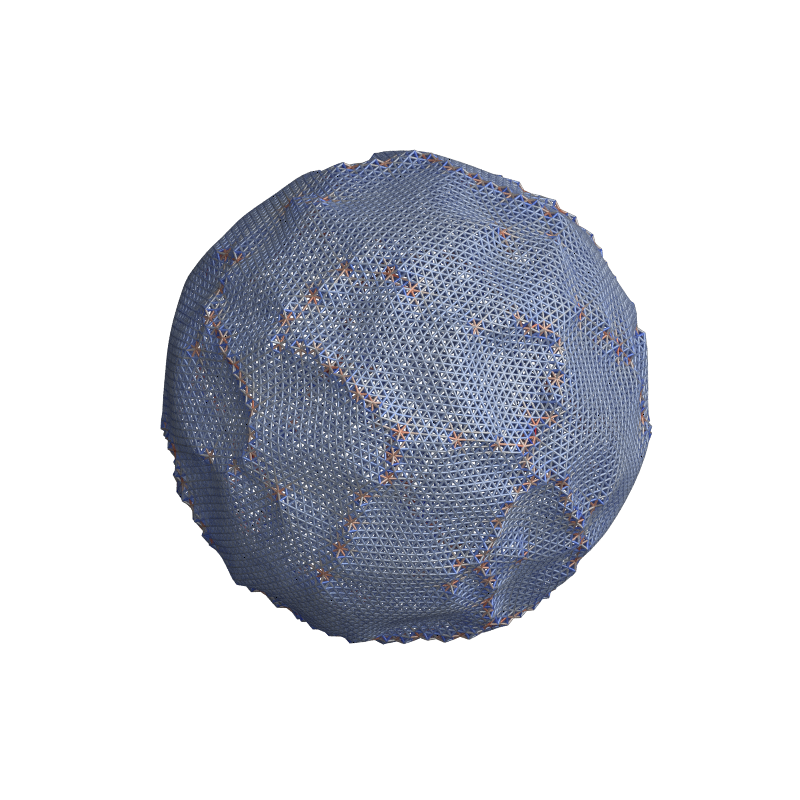

In [20]:
# Visualize relaxed mesh
snapshot_relaxed = system.state.get_snapshot()

render.fresnel(snapshot_relaxed, show='strains', cmap='coolwarm', outline=0, rescale_backbone_bonds=vertex_rescale_factor).static(height=800, width=800)

In [21]:
# HooMD to openMM time conversion factor
t_conv = (1.67377*10**-27/(1.380649*10**-23*300))**0.5

In [22]:
# Set full force field
force_field = relax_field + repulsion_forces

In [23]:
# Unset relaxation engine
system.operations.remove(fire)
system.operations.remove(system.operations.writers[0])

In [24]:
# Initialize Langevin thermostat
langevin = hoomd.md.methods.Langevin(filter=hoomd.filter.All(), kT=1.0)
integrator = hoomd.md.Integrator(dt=10*t_conv, methods=[langevin], forces=force_field)

In [25]:
# Update simulation object
logger = log.get_logger(system)

system.operations.integrator = integrator
system.operations.writers.append(log.table_formatter(logger, period=5e4))

In [26]:
# Run
system.run(1e6)

Simulation.timestep  Simulation.tps     Status.etr    Thermo.kinetic_temperature
      250000           6107.69399     0:02:35.541519           1.00663          
      300000           7732.54768     0:01:56.391135           1.01028          
      350000           8481.91150     0:01:40.213260           0.98825          
      400000           8912.41680     0:01:29.762409           1.00392          
      450000           9190.00616     0:01:21.610391           0.99647          
      500000           9387.93672     0:01:14.563775           0.99595          
      550000           9535.55165     0:01:08.165957           1.00993          
      600000           9646.90387     0:01:02.196121           0.99890          
      650000           9737.07081     0:00:56.485160           1.00031          
      700000           9811.39383     0:00:50.961159           1.01076          
      750000           9871.13302     0:00:45.587472           0.99819          
      800000           9922.

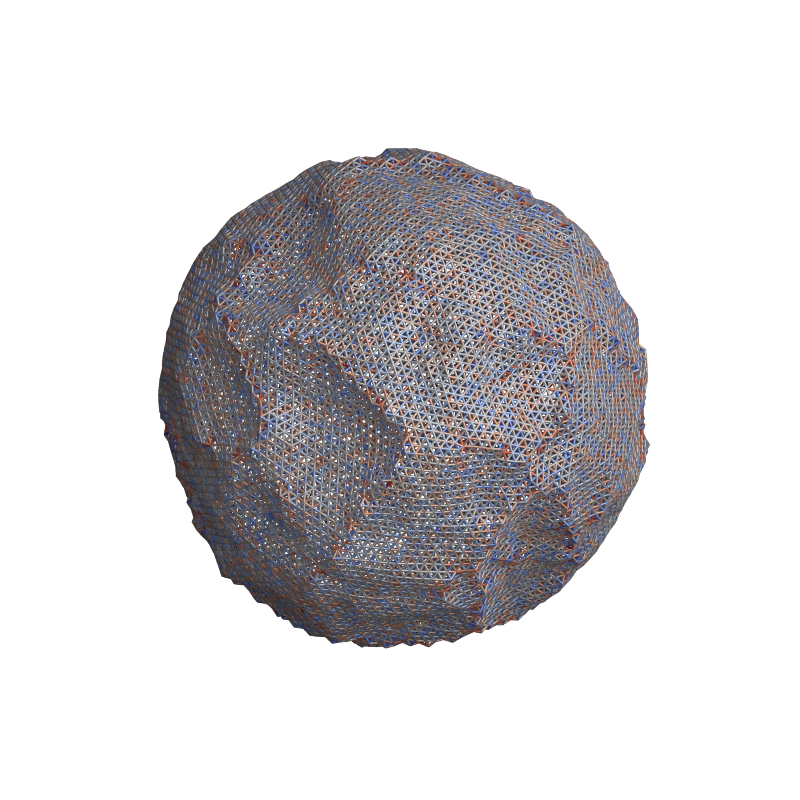

In [27]:
# Visualize thermalized membrane
snapshot_therm = system.state.get_snapshot()

render.fresnel(snapshot_therm, show='strains', cmap='coolwarm', outline=0, rescale_backbone_bonds=vertex_rescale_factor).static(height=800, width=800)

In [28]:
# Identify left- and right-most vertices
leftmost_vertex_id = np.argmin(snapshot_therm.particles.position[:, 0])
rightmost_vertex_id = np.argmax(snapshot_therm.particles.position[:, 0])

In [29]:
# Single out extremal vertices for point force application
leftmost_vertex = hoomd.filter.Tags(leftmost_vertex_id)
rightmost_vertex = hoomd.filter.Tags(rightmost_vertex_id)

In [30]:
# Setup stretching force along the x axis with magnitude ~0.1 nN
stretching_forces = forces.get_constant_forces([leftmost_vertex, rightmost_vertex], **force_dict)
integrator.forces = force_field + stretching_forces

In [31]:
# Run
system.run(1e6)

      1250000          4038.79420     0:03:55.218719           0.99886          
      1300000          5732.44136     0:02:37.001170           0.98790          
      1350000          6658.19531     0:02:07.662221           0.99594          
      1400000          7244.45650     0:01:50.429264           0.98919          
      1450000          7646.60528     0:01:38.082740           1.01109          
      1500000          7945.25258     0:01:28.102926           1.00464          
      1550000          8175.78473     0:01:19.503072           0.99629          
      1600000          8360.50871     0:01:11.765968           1.01420          
      1650000          8506.78695     0:01:04.654258           0.99449          
      1700000          8631.42643     0:00:57.927853           0.99802          
      1750000          8733.88110     0:00:51.523486           1.00634          
      1800000          8819.66661     0:00:45.353188           0.99871          
      1850000          8893.

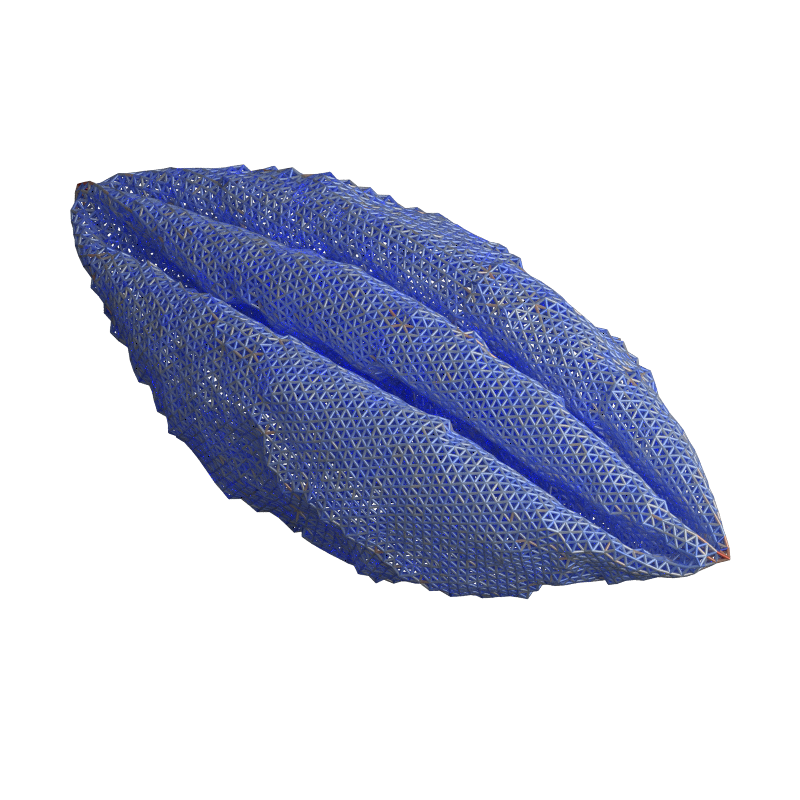

In [32]:
# Visualize stretched membrane
snapshot_stretched = system.state.get_snapshot()

render.fresnel(snapshot_stretched, show='strains', cmap='coolwarm', outline=0, rescale_backbone_bonds=vertex_rescale_factor).static(height=800, width=800)